In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')
df = pd.read_csv('../data/training.csv', index_col=0)

# Exploratory Data Analysis

We are provided with two datasets:
* Training set (9500 samples)
* Test set (500 samples)

Each sample consists of:
* The **article number**
* A comma-separated **word list**
* The determined **topic**

Each sample has already been pre-processed:
* Words are all lowercase
* Punctuation removed
* Stop-words removed
* Lemmatised/Stemmed words (*Can we tell which?*)
* Any others?

## Article words

From the following random sample we can see that words are in the order that they appear in the text, however, duplicate words have been grouped together. As the word are **not** in true sequential order this will impact performance when using bigrams, trigrams, LSTMs, etc.. or any other method that requires sequences.

In [2]:
# Random sample
print(df.sample().values[0][0])

option,stock,complet,corp,offer,initial,net,net,net,carolin,carolin,nk,nk,nk,exercis,percent,pct,public,allot,expect,expect,common,thursday


## Class Distribution

As seen in the graph below, the training dataset suffers from **class imbalance**, a condition where classes are not equally represented across the samples.
We will have to factor this in during the development of our models and explore methods to handle the impacts of the imbalance.

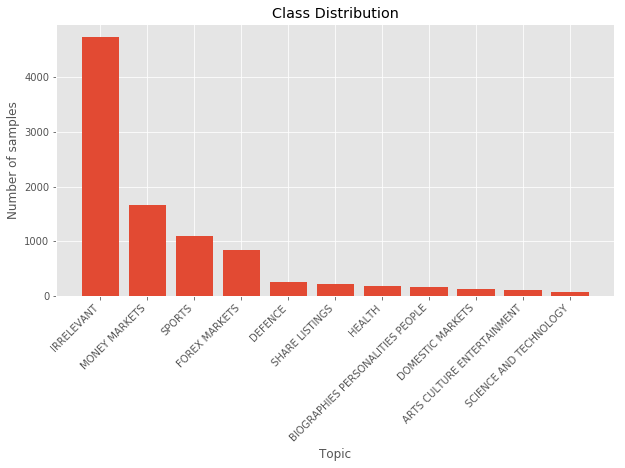

In [3]:
class_dist = df.groupby('topic').size().reset_index(name='counts').sort_values('counts', ascending=False)
plt.figure(figsize=(10,5))
plt.bar(class_dist['topic'], class_dist['counts'])
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of samples')
plt.xlabel('Topic');

## Feature Statistics

### Total words

In [4]:
df['num_words'] = df['article_words'].str.split(',').str.len()
print(f'{df.num_words.sum():,}')

1,213,216


### Distinct words

In [5]:
from collections import Counter
freq_dist = Counter()
for index, row in df.iterrows():
    freq_dist.update(row.article_words.split(','))
print(f'{len(freq_dist):,}')

35,823


### Words per sample

In [6]:
print(df.num_words.describe())

count    9500.000000
mean      127.706947
std        98.752819
min         8.000000
25%        54.000000
50%        97.000000
75%       176.000000
max      1935.000000
Name: num_words, dtype: float64


### Top word frequencies

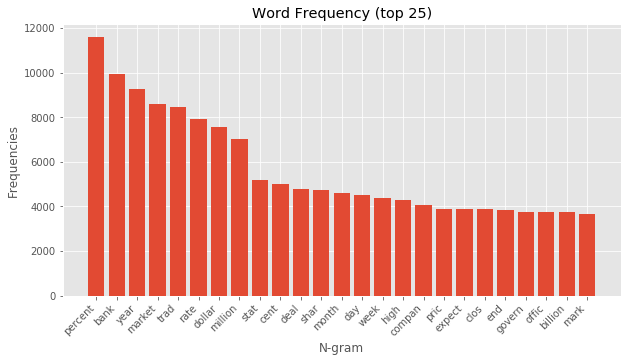

In [7]:
TOP_N = 25
top_words = freq_dist.most_common(TOP_N)
plt.figure(figsize=(10,5))
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.xticks(rotation=45, ha='right')
plt.xlabel('N-gram')
plt.ylabel('Frequencies')
plt.title(f'Word Frequency (top {TOP_N})');

### Article length distribution

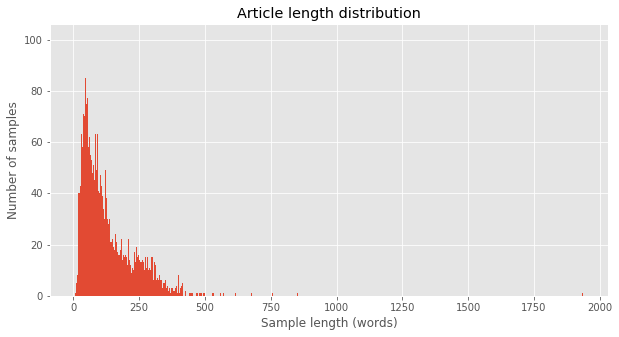

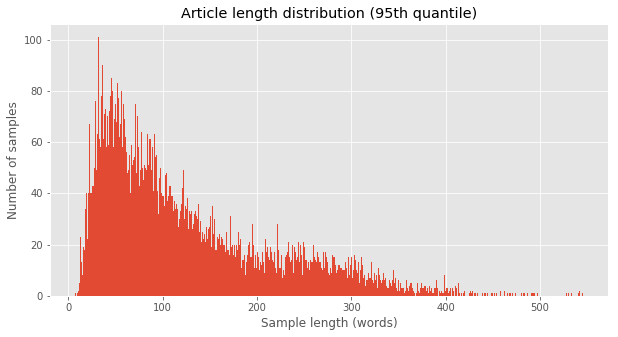

In [8]:
len_dist = df.groupby('num_words').size().reset_index(name='counts')
plt.figure(figsize=(10,5))
plt.bar(len_dist.num_words, len_dist.counts, width=1.0)
plt.title('Article length distribution')
plt.xlabel('Sample length (words)')
plt.ylabel('Number of samples');

len_dist_95 = len_dist[len_dist['num_words'] < len_dist['num_words'].quantile(0.95)]
plt.figure(figsize=(10,5))
plt.bar(len_dist_95.num_words, len_dist_95.counts, width=1.0)
plt.title('Article length distribution (95th quantile)')
plt.xlabel('Sample length (words)')
plt.ylabel('Number of samples');

# Article length by topic

The article lengths are similar over all of the topics.

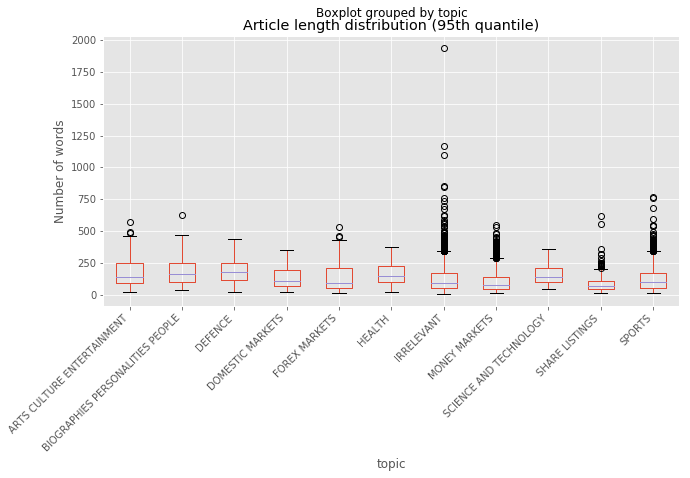

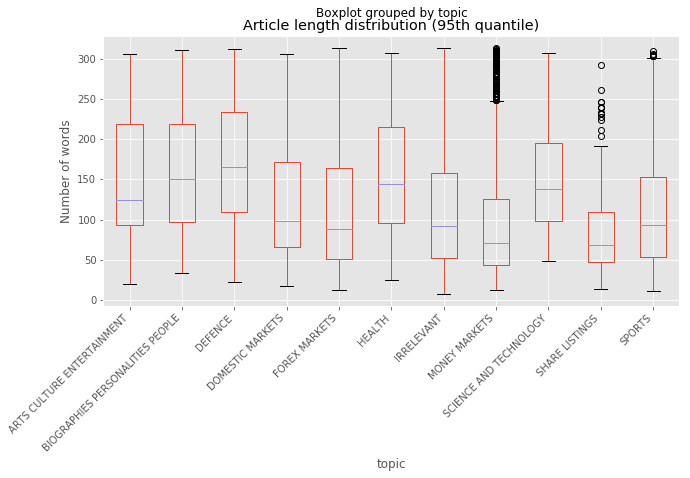

In [9]:
plot = df.boxplot(column='num_words', by='topic', figsize=(10,5))
plot.set_title('Article length distribution (95th quantile)')
plot.set_ylabel('Number of words')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right');

df_95 = df[df['num_words'] < df['num_words'].quantile(0.95)]

plot = df_95.boxplot(column='num_words', by='topic', figsize=(10,5))
plot.set_title('Article length distribution (95th quantile)')
plot.set_ylabel('Number of words')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45, ha='right');

## Words in GloVe 6D pre-trained embedding matrix

In [10]:
vocab = set()
for index, row in df.iterrows():
    vocab.update(row.article_words.split(','))
glove = []
with open('../models/.vector_cache/glove.6B.50d.txt') as file:
    for line in file.readlines():
        glove.append(line.split()[0])

FileNotFoundError: [Errno 2] No such file or directory: '../models/.vector_cache/glove.6B.50d.txt'

In [11]:
found = vocab.intersection(glove)
print(f'Features found in GloVe vectors: {len(found):,}/{len(vocab):,} ({len(found)/len(vocab):.2f}%)')

Features found in GloVe vectors: 0/35,823 (0.00%)


In [20]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [22]:
reindexed_data = df['article_words']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = len(np.unique((np.array(df['topic'].values))))
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words
    
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  bank percent rate
Topic 2:  shar compan million
Topic 3:  dollar mark yen
Topic 4:  net loss shr
Topic 5:  lbs stock oil
Topic 6:  yen parent million
Topic 7:  crown fix mark
Topic 8:  pct roubl auction
Topic 9:  play match cup
Topic 10:  hond lank sri
Topic 11:  rupee india kerb


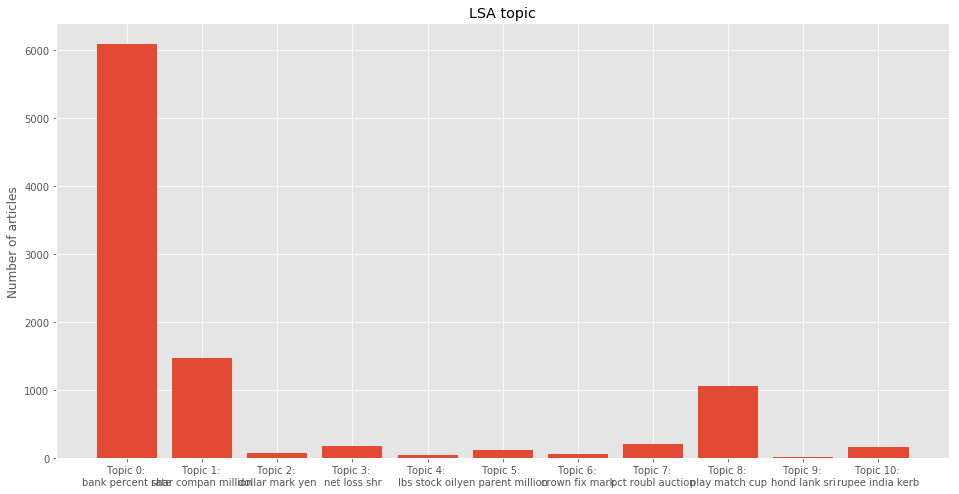

In [26]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of articles');
ax.set_title('LSA topic');
plt.show();

In [27]:
labels

['Topic 0: \nbank percent rate',
 'Topic 1: \nshar compan million',
 'Topic 8: \nplay match cup',
 'Topic 7: \npct roubl auction',
 'Topic 3: \nnet loss shr',
 'Topic 2: \ndollar mark yen',
 'Topic 5: \nyen parent million',
 'Topic 10: \nrupee india kerb',
 'Topic 4: \nlbs stock oil',
 'Topic 6: \ncrown fix mark',
 'Topic 9: \nhond lank sri']

In [47]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_topics = le.fit_transform(df['topic'])

/usr/local/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../usr/local/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


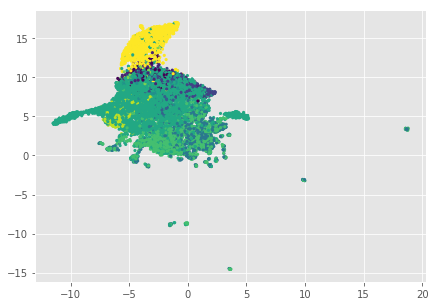

In [49]:
import umap.umap_ as umap

X_topics = lsa_topic_matrix
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = labels_topics,
s = 10,# size
edgecolor='none'
)
plt.show()